## Transfer Learning on cats vs dogs dataset with VGG16

## Explanation

When working with small datasets on Image Classification tasks , using a pretrainded model can really increase your results.


If the original dataset on which the model was trained is large enough , the spacial hierarchy of features learned by the pretrained model can act as generic model of the visual world and then it's features can prove usefully on datasets with other classes than the original it was trained on.

Here i will cover the two most common ways to use a pretrained model :
 - ### Feature Extraction
 - ### Fine Turing

## Feature Extraction With VGG16

Feaure Extraction consist into using the representations learned by the pretrained model to predict features from  new classes , then run these features trough a new classifier from scratch.

A convolutional model can commoly be separated into two main parts :
 - The convolutional base (the set of Conv and Normalization layers at the top of the model )

 - The classifier (The set of Densily connected layers at the bottom of the model) 

<br/>

The **Convolutional Base** is the part of the model that extract the most generic features about the images( In case of a computer vision task) and the **Densily connected classifier** is about to extract features relatives to a specific class . 

So the best thing to do is to only use the **convolutional base** when dealing with pretrained Computer vision models.

In our case we classifing horse vs humans Images and the ImageNet Dataset on wich our model was trained contains images of Cats and Dogs so it could be tempting to use the **Densely connected Classifier** from our model also (and it should give us nice results) but , to cover the most large usage i'm gonna use only the Conv Base and write my one Classifier .

<br/>

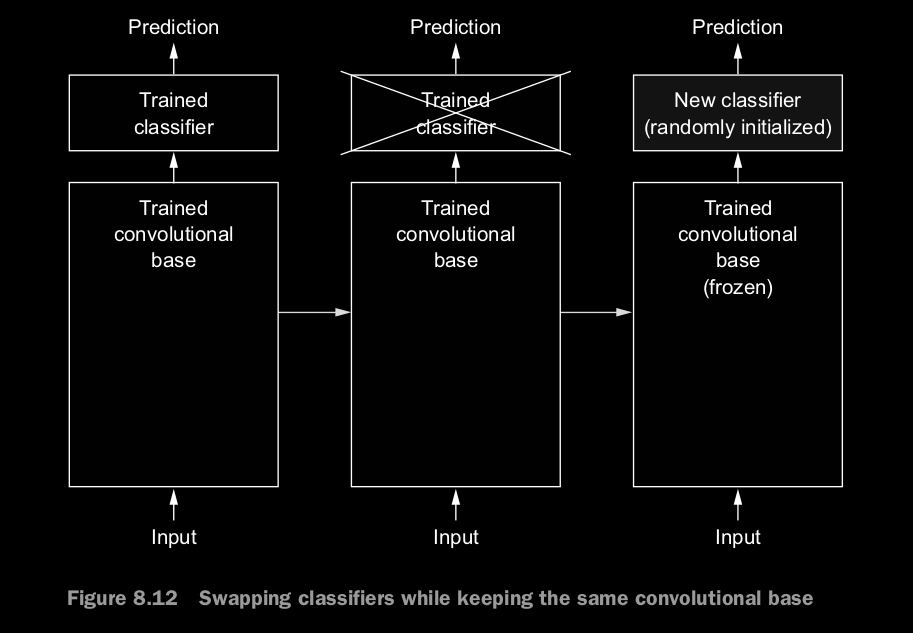

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt 
import os, shutil, pathlib



In [ ]:
#Instanciating the VGG16

conv_base = keras.applications.vgg16.VGG16(
    #weights is about the weight checkpoint from wich inializing the model
    weights = "imagenet",
    #include_top is about adding or not the densely connected classifier at the top of the model
    include_top = False,
    input_shape = (150, 150, 3)
)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# The Data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"augustinkpadonou","key":"569bdd1c48e4763c45bbe708248d0527"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:38<00:00, 24.0MB/s]
100% 812M/812M [00:38<00:00, 22.3MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
                                for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
                                dst=dir / fname)

In [8]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
      new_base_dir / "train",
      image_size=(180, 180),
      batch_size=32)


validation_dataset = image_dataset_from_directory(
      new_base_dir / "validation",
      image_size=(180, 180),
      batch_size=32)


test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Feature Extraction

## Simple Feature Extraction


In [ ]:


def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    #here we preprocess our images with the built-in preprocessor of the vgg16 model
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    #we fit the model with image batches and then save predictions into lists
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  #then we return numpy array of of the features and labels
  return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 4s 4s/step


_after this we gonna use the features got from the pretrainded model as the input for a densely connected classifier we will write._

In [ ]:
train_features.shape

(2000, 5, 5, 512)

In [ ]:
from keras import layers

inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
  train_features, train_labels,
  epochs=20,
  validation_data=(val_features, val_labels),
  callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 29ms/step - loss: 19.0199 - accuracy: 0.9240 - val_loss: 3.6078 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 2s 26ms/step - loss: 4.8216 - accuracy: 0.9720 - val_loss: 4.8502 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 2.3609 - accuracy: 0.9820 - val_loss: 4.6118 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 2s 25ms/step - loss: 1.1014 - accuracy: 0.9905 - val_loss: 6.1677 - val_accuracy: 0.9660
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 0.9455 - accuracy: 0.9920 - val_loss: 5.9850 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 0.8806 - accuracy: 0.9925 - val_loss: 5.8961 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 2s 25ms/step - loss: 0.4883 - accuracy: 0.9960 - val_loss: 5.2065 - val_accuracy: 0.9740
Epoch 8/20
6

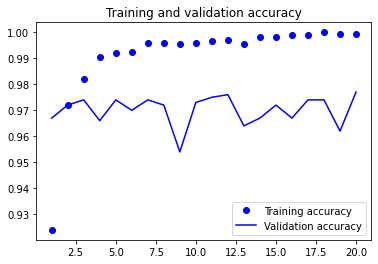

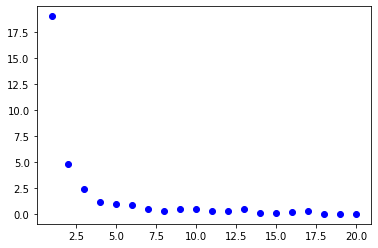

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.savefig('history.jpg')


In [ ]:
model.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 7.6020 - accuracy: 0.9690


[7.6020307540893555, 0.968999981880188]

With Feature Extraction we reach 96% of accuracy on the test set , It's because ImageNet contains many images of dogs an cat and the model easily recognise patterns learned from ImageNet in our Dataset.

But you can also see,, we're severely overfitting.
A way to improve our accuracy and avoid overfitting here would be to use Image Augmentation.
This second solution should be more expensive and slower than our actual one but it would bring better results.

## Feature Extraction with Data Augmentation

What we are going to do here is to chain a custom densely connected classifier to our convolution base extracted from vgg16.

On important fact is that we are going to freeze the layers of the conv_base.

**WHY ?**

  Training the conv_base layers with our randomly initialized dense network will propagate weights updates trough our model and corrupt the representations the vgg16 model has already learned.


In [56]:
# lets' instanciate our convolutional base from vgg16 


conv_base = keras.applications.vgg16.VGG16(
    weights ='imagenet',
    include_top = False     )

len(conv_base.trainable_weights)
## as you can see we have 26 trainanble weights by default in the model

26

In [57]:
conv_base.trainable = False
#now all the weights are no more trainnable and won't be modified while training it with our custom dense network
len(conv_base.trainable_weights)

0

### Data Augmentation 


As overefitting is caused by having too fee samples , giving more data based on the original samples to the model is a very great solution.

This is what Data Augmentation is all about : 'Augmenting' the data by applying a number of random operations on it.
This make the model never see a same sample twice while training and it can generalize better.

Data Augmentaton can be initialized by very different ways such as :

 - By using the **ImageDataGenerator** util from _tensorflow.keras.preprocessing.image_
 - Or by using keras built-in layers as **RandomFlip**, **RandomRotation** ....

_Note : Here we will use keras bult-in layers for simplicity_

In [12]:
# let's implement data augmentation 
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),

])

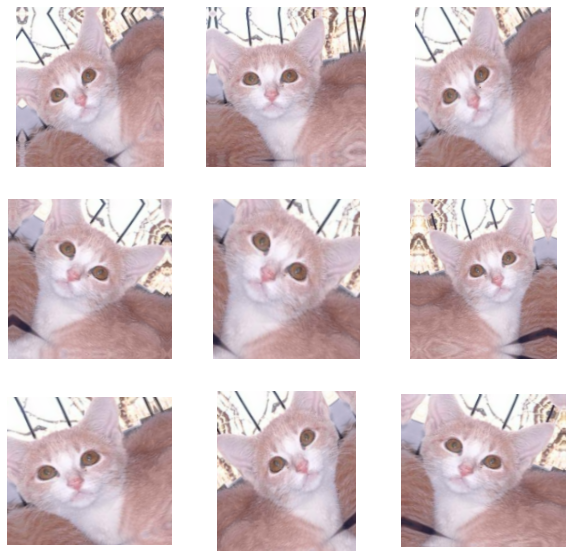

In [ ]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1): 
  for i in range(9):
    augmented_images = data_augmentation(images) 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8")) 
    plt.axis("off")

View the *Augmented* images

### Adding Data Augmentation and Classifier to our conv_base

In [58]:
inputs = keras.Input(shape=(180, 180, 3))

#adding data augmentation
x = data_augmentation(inputs)

#preprocess using vgg16 preprocessor
x = keras.applications.vgg16.preprocess_input(x)

#adding conv_base
x = conv_base(x)

x = layers.Flatten()(x)

#adding dense classifier
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)


model = keras.Model(inputs, outputs)

In [59]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0   

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer ='rmsprop',
              metrics = ['accuracy'])

In [61]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")    ]

In [62]:
history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 206ms/step - loss: 18.5334 - accuracy: 0.8950 - val_loss: 34.4407 - val_accuracy: 0.8450
Epoch 2/50
63/63 [==============================] - 13s 204ms/step - loss: 6.9450 - accuracy: 0.9500 - val_loss: 5.0254 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 13s 205ms/step - loss: 6.9770 - accuracy: 0.9520 - val_loss: 3.8727 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 13s 203ms/step - loss: 5.0124 - accuracy: 0.9595 - val_loss: 4.1010 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 13s 204ms/step - loss: 4.8004 - accuracy: 0.9640 - val_loss: 6.1169 - val_accuracy: 0.9650
Epoch 6/50
63/63 [==============================] - 13s 205ms/step - loss: 4.1529 - accuracy: 0.9650 - val_loss: 4.2988 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 13s 209ms/step - loss: 3.4880 - accuracy: 0.9740 - val_loss: 3.3818 - val_accuracy: 0.98

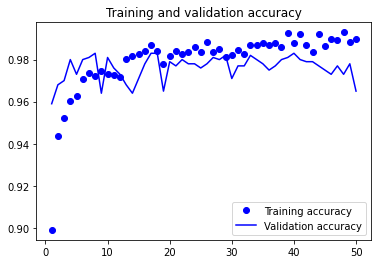

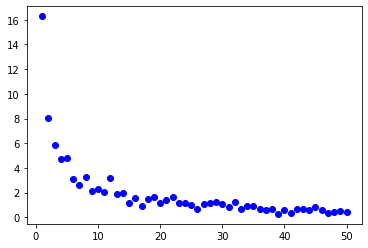

In [18]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.savefig('history.jpg')


In [55]:
test_model = keras.models.load_model('feature_extraction_with_data_augmentation.keras')
loss , acc = test_model.evaluate(test_dataset)
print(f'Test Accuracy :  {acc:.3f} ')

63/63 [==============================] - 8s 112ms/step - loss: 2.1403 - accuracy: 0.9755
Test Accuracy :  0.975 


This technique is more power expensive than the first one but we seems to overfit later and our test accuracy is higher than with our first appproch 

Note that only the densely connected classifier we add has been trained 

In [19]:
len(model.trainable_weights)

4

These four weights are the weights matrix  and the bias vector of our two dense layers

In [21]:
## In the next session we will face the second way to use pretrainded model on compviz tasks : Fine-turing 

# Fine-Turing with a pretrained model

One complementary techinque to feature extraction is fine turing.

What is it about ?

Fine turing is slicly different of feature extraction by one thing :
Instead of freezing all the layers in the conv base , we are going to unfreeze some of the top layers of our conv base , train a densely connected classifier , add them toghether and retrain the final model on our data.

❔ Why do we unfreeze train some layers :

 We unfreeze some top layers of the pretrained model to slightly adjust the representations of the model in order to make them more relevent for our task  

❔Why do we train the classifier before adding it to model :

With a randomly initilized classifier the error signal will propagate through the unfreezed layers and destroy previously learned representations of the layers. and that's not what we want .


<br/>

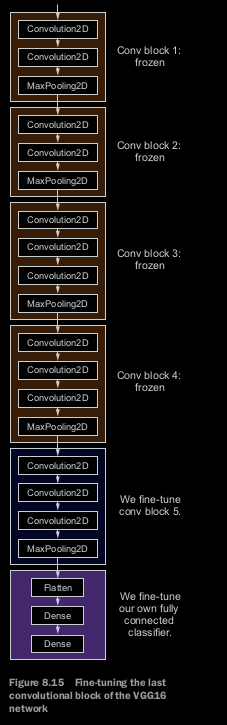

In [24]:
# Here we will fine-tune the last three convolution layers of the conv_base , hte block5 layers

In [63]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

len(conv_base.trainable_weights)

6

We now have six trainable weights , a weights matrix and bias vector for our three conv layers.

Note : MaxPooling2D is a normalization layer and don't have trainble weights

In the previous section we have : added our customm layer on the pretrained freeze con_base and trained only the classifier we added.

Now we after we have unfreeze some layers in the conv_base , we have to compile the model and then retrain the unfreezed layers and our classifier .

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics = ['accuracy'])

In [65]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = 'fine_tuning.keras',
    save_best_only = True
)]

In [66]:
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 30, 
    callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 17s 241ms/step - loss: 0.4281 - accuracy: 0.9920 - val_loss: 1.6875 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 15s 230ms/step - loss: 0.3761 - accuracy: 0.9940 - val_loss: 1.4419 - val_accuracy: 0.9840
Epoch 3/30
63/63 [==============================] - 15s 228ms/step - loss: 0.3974 - accuracy: 0.9915 - val_loss: 1.2060 - val_accuracy: 0.9850
Epoch 4/30
63/63 [==============================] - 14s 223ms/step - loss: 0.3308 - accuracy: 0.9910 - val_loss: 1.2745 - val_accuracy: 0.9860
Epoch 5/30
63/63 [==============================] - 14s 223ms/step - loss: 0.3771 - accuracy: 0.9905 - val_loss: 1.2945 - val_accuracy: 0.9830
Epoch 6/30
63/63 [==============================] - 15s 230ms/step - loss: 0.1514 - accuracy: 0.9945 - val_loss: 1.3877 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 14s 225ms/step - loss: 0.2612 - accuracy: 0.9925 - val_loss: 1.4581 - val_accuracy: 0.9830

In [67]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 120ms/step - loss: 1.8350 - accuracy: 0.9740
Test accuracy: 0.974


Here our accuracy after fine turing is same as the previuos approch but fine tuning can be a very usefull approch to implement when doing computer viz , remenber hte first goal is to have a model with the best generalizatio possible and and knowing about these techniques can be very useful on any computer vision task

# Summary

 - Data Augmentation is a powerful way to resolve overfitting issues while working on small datasets.

 - It's easy to use pretrained models on our datasets via feature extraction.
 - As a complement to feature extraction , fine-tuning can help adapting the previously learned representatios to the new dataset and push the performance further

## References :
 - [Deep Learning With Python](https://www.manning.com/books/deep-learning-with-python-second-edition) - Robert Chollet 